In [44]:
!pip install pyworld
!pip install soundfile
!pip install scipy
!pip install numpy
!pip install matplotlib

In [76]:
import pyworld as pw
from scipy.io import wavfile as wf
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

def upload_stuff():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
    with open(fn, 'w') as f:
      f.write(uploaded[fn])
  
  return uploaded
!ls

clip1.wav  datalab


In [7]:
upload_stuff()
!ls

User uploaded file "clip1.wav" with length 1275726 bytes
clip1.wav  datalab  mnist.pkl.gz  theta_best.dat


In [0]:
file = 'clip1.wav'

fs, x = wf.read(file)

Nwindows = 1447
(1447, 1025)


Text(0,0.5,u'band aperiodicities')

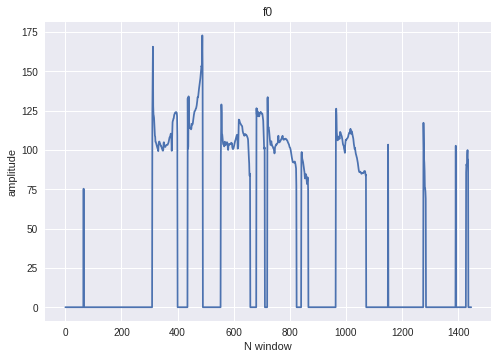

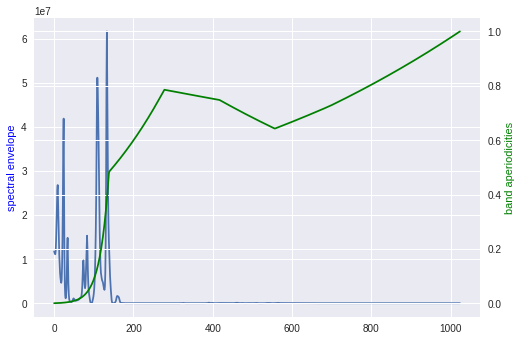

In [12]:
if x.ndim is 2:
    x = x[:, 0].squeeze()
    
x = x.copy(order='C')

f0, sp, ap = pw.wav2world(x.astype(float), fs)

Nwindows = f0.shape[0]
print("Nwindows = %d" % Nwindows)
print(sp.shape)


plt.figure()
plt.plot(range(Nwindows), f0)
plt.title("f0")
plt.xlabel("N window")
plt.ylabel("amplitude")


nWindow = 370

plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(sp[nWindow,1:])
ax1.set_ylabel('spectral envelope', color='b')
ax2.plot(ap[nWindow,1:], 'g')
ax2.set_ylabel('band aperiodicities', color='g')


In [7]:
upload_stuff()
!ls

NameError: ignored

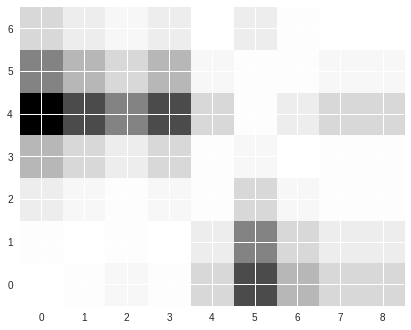

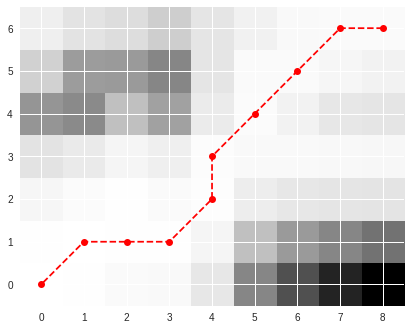

In [138]:
import numpy as np
import matplotlib.pyplot as plt

def elementwyse_l2(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    if x.ndim is 1:
        x = x.reshape(-1,1)
        x_norm = (x**2).reshape(-1, 1)
    else:
        x_norm = (x**2).sum(1).reshape(-1, 1)
        
    if y is not None:
        if y.ndim is 1:
            y = y.reshape(-1, 1)
            y_norm = (y**2).reshape(1, -1)
        else:
            y_norm = (y**2).sum(1).reshape(1, -1)
    else:
        y = x
        y_norm = x_norm.reshape(1, -1)

    dist = x_norm + y_norm - 2.0 * np.matmul(x, y.T)
    return dist
  
def genate_Cmtx(dists):  
  sz = dists.shape
  c = dists
  d = 100000*np.ones(sz)
  #torch:
  #sz[0] = i vertical
  #sz[1] = j horizontal
  d[:, 0] = c[:, 0]
  
  for j in range(1, sz[1]):
    for i in range(sz[0]):

      if i is 0:
        d[i, j] = c[i,j] + d[i,j-1]
      else:
        d[i, j] = c[i,j] + np.array([d[i,j-1], d[i-1,j], d[i-1,j-1]]).min()
        
  return d  

def dtw_backtracking(c, start):
  # Work in progress
  posV = np.array([start[0]])
  posH = np.array([start[1]])
  i = 0
  
  while posH[i] != 0:
    
    if posV[i] == 0:
      opts = 2

    else:
      opt1 = c[posV[i] - 1, posH[i]]
      opt2 = c[posV[i], posH[i] - 1]
      opt3 = c[posV[i] - 1, posH[i] - 1]
      
      aa = np.array([opt1, opt2, opt3], dtype=np.float32)
      opts = np.argmin(aa)
      
    nextV = posV[i] - (opts == 0 or opts == 2)
    nextH = posH[i] - (opts == 1 or opts == 2)

    posV = np.append(posV, nextV)
    posH = np.append(posH, nextH)
    
    i += 1
    
  
  return posV, posH
  
  
s = np.array([0, 1, 3, 5, 8, 6, 4])
t = np.array([0, 1, 2, 1, 4, 7, 5, 4, 4])

D = elementwyse_l2(s, t)
C = genate_Cmtx(D)
start = [6,8]
posV, posH = dtw_backtracking(C, start)

plt.figure()
plt.imshow(D)
plt.gca().invert_yaxis()
plt.figure()
plt.imshow(C)
plt.plot(posH, posV, 'r--o')
plt.gca().invert_yaxis()


In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [101]:
# Dynamic time warping in PYTORCH
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile as wf
file_alberto = 'clip1.wav'
file_javi = 'clip1.wav'

fs, x_alberto = wf.read(file_alberto)
fs, x_javi = wf.read(file_javi)


# def elementwyse_l2(x, y=None):
  
#   if y is None:
#     y = x
#   # input 
#   #Nx = x.shape[0]
#   #Ny = y.shape[0]
#   #dims = x.shape[1]
  
#   dist = (x.unsqueeze(1) - y.unsqueeze(0)).pow(2).sum(2)
#   return dist
#this function is an alternative to the previous

s = torch.FloatTensor([0, 1, 3, 5, 8, 6, 4])
t = torch.FloatTensor([0, 1, 2, 1, 4, 7, 5, 4, 4])

def elementwyse_l2_pt(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x = x.view(x.shape[0], -1)
    print(x.shape)
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y = y.view(y.shape[0], -1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y = x
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist

def genate_Cmtx_pt(dists):  
  sz = dists.shape
  c = dists
  d = 100000*torch.ones(sz)
  #torch:
  #sz[0] = i vertical
  #sz[1] = j horizontal
  d[:, 0] = c[:, 0]
  
  for j in range(1, sz[1]):
    for i in range(sz[0]):

      if i is 0:
        d[i, j] = c[i,j] + d[i,j-1]
      else:
        d[i, j] = c[i,j] + torch.FloatTensor([d[i,j-1], d[i-1,j], d[i-1,j-1]]).min()
        
  return d


def dtw_backtracking_pt(c, start):
  # Work in progress
  posV = torch.IntTensor([start[0]])
  posH = torch.IntTensor([start[1]])
  i = 0
  
  while posH[i] != 0:
    
    if posV[i] is 0:
      opts = 2
      addcost = c[posV[i], posH[i] - 1]

    else:
      opt1 = c[posV[i] - 1, posH[i]]
      opt2 = c[posV[i], posH[i] - 1]
      opt3 = c[posV[i] - 1, posH[i] - 1]
      [addcost, opts] = torch.min(torch.FloatTensor([opt1, opt2, opt3]))
      print(opts)
      
    nextV = torch.IntTensor([posV[i] - (opts == 1 or opts == 3)])
    nextH = torch.IntTensor([posH[i] - (opts == 2 or opts == 3)])

    posV = torch.cat((posV, nextV), 0)
    posH = torch.cat((posH, nextH), 0)
    
    i += 1
    
  
  return posV, posH


XA = torch.ones(4,2)
XJ = torch.ones(6,2)*3

D = elementwyse_l2_pt(s, t)
C = genate_Cmtx_pt(D)
start = torch.IntTensor([6,8])
posV, posH = dtw_backtracking_pt(C, start)

plt.figure()
plt.imshow(D)

plt.figure()
plt.imshow(C)
plt.scatter(posH, posV, color='r')


  

torch.Size([7, 1])


TypeError: ignored

In [82]:
a = torch.ones(3)
print(type(a))
a.view(a.shape[0],-1).sum(1)

<class 'torch.FloatTensor'>



 1
 1
 1
[torch.FloatTensor of size 3]

In [66]:
#### linear regresion

import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168],
                    [9.779], [6.182], [7.59], [2.167], [7.042],
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

t_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573],
                    [3.366], [2.596], [2.53], [1.221], [2.827],
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

x_t = torch.from_numpy(x_train)
t_t = torch.from_numpy(t_train)


class my_linear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(my_linear, self).__init__()
        #self.linear = nn.Linear(input_dim, output_dim, bias=True)
        self.W = None;#nn.Parameter()
          
    def forward(self, x):
        #out = self.linear(x)
        x = torch.cat((torch.ones(x.shape[0],1), x) ,1).t()
        print(x.shape)
        y = self.W.t().matmul(x)
        return y
      
    def fit_LS(self, x, t):
        x = torch.cat((torch.ones(x.shape[0],1), x) ,1)
        pseusoInvX = torch.inverse(torch.matmul(x.t(), x)).matmul(x.t())
        self.W = pseusoInvX.matmul(t)
        
        
        
model = my_linear(1,1)   
       
model.fit_LS(x_t, t_t)
print(model.W.shape)
print(model(x_t[0]))


torch.Size([2, 1])
torch.Size([2, 1])

 1.6056
[torch.FloatTensor of size 1x1]



In [0]:
######################################################################### Alberto

In [68]:
import pyworld as pw
from scipy.io import wavfile as wf
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

file = 'clip1.wav'

fs, x = wf.read(file)

if x.ndim is 2:
    x = x[:, 0].squeeze()
    
x = x.copy(order='C').astype(float)

print(x.shape)


(318912,)


In [0]:
"""Harvest F0 extraction algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    fs : int
        Sample rate of input signal in Hz.
    f0_floor : float
        Lower F0 limit in Hz.
        Default: 71.0
    f0_ceil : float
        Upper F0 limit in Hz.
        Default: 800.0
    frame_period : float
        Period between consecutive frames in milliseconds.
        Default: 5.0
    Returns
    -------
    f0 : ndarray
        Estimated F0 contour.
    temporal_positions : ndarray
        Temporal position of each frame.
    """

f0_floor = 71.0
f0_ceil = 800.0
frame_period = 5.0
f0, temporal_positions = pw.harvest(x, fs,f0_floor, f0_ceil, frame_period)

#plt.figure()
#plt.plot(temporal_positions, f0)


(1447,)


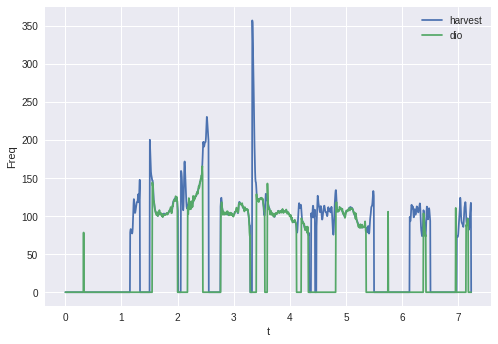

In [72]:
"""DIO F0 extraction algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    fs : int
        Sample rate of input signal in Hz.
    f0_floor : float
        Lower F0 limit in Hz.
        Default: 71.0
    f0_ceil : float
        Upper F0 limit in Hz.
        Default: 800.0
    channels_in_octave : float
        Resolution of multiband processing; normally shouldn't be changed.
        Default: 2.0
    frame_period : float
        Period between consecutive frames in milliseconds.
        Default: 5.0
    speed : int
        The F0 estimator may downsample the input signal using this integer factor
        (range [1;12]). The algorithm will then operate on a signal at fs/speed Hz
        to reduce computational complexity, but high values may negatively impact
        accuracy.
        Default: 1 (no downsampling)
    allowed_range : float
        Threshold for voiced/unvoiced decision. Can be any value >= 0, but 0.02 to 0.2
        is a reasonable range. Lower values will cause more frames to be considered
        unvoiced (in the extreme case of `threshold=0`, almost all frames will be unvoiced).
        Default: 0.1
    Returns
    -------
    f0 : ndarray
        Estimated F0 contour.
    temporal_positions : ndarray
        Temporal position of each frame.
    """

f0_floor = 71.0
f0_ceil = 800.0
channels_in_octave = 2.0
frame_period = 5
speed= 1
allowed_range = 0.1
f0_dio, temporal_positions_dio = pw.dio(x, fs,f0_floor, f0_ceil, channels_in_octave, 
                                frame_period, speed, allowed_range)

"""StoneMask F0 refinement algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    f0 : ndarray
        Input F0 contour.
    temporal_positions : ndarray
        Temporal positions of each frame.
    fs : int
        Sample rate of input signal in Hz.
    Returns
    -------
    refined_f0 : ndarray
        Refined F0 contour.
    """
f0_sm = pw.stonemask(x, f0, temporal_positions, fs)

plt.figure()
plt.plot(temporal_positions, f0, label="harvest")
plt.plot(temporal_positions, f0_dio, label="dio")
#plt.plot(temporal_positions, f0_sm, label="stonemask")
plt.ylabel('Freq')
plt.xlabel('t')
print(f0.shape)

plt.legend()

(1447, 1025)


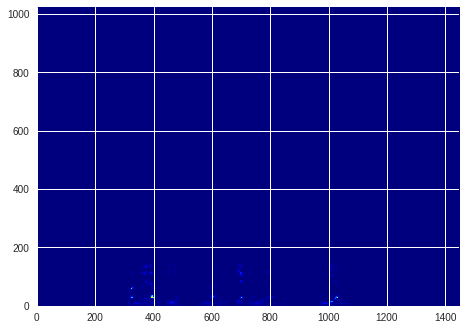

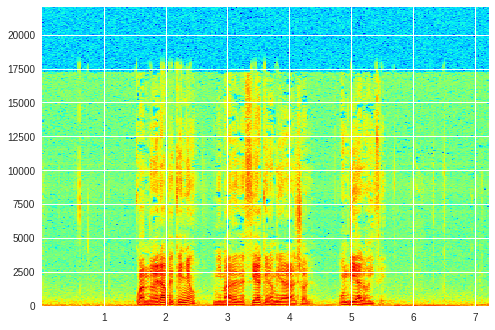

In [71]:
"""CheapTrick harmonic spectral envelope estimation algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    f0 : ndarray
        Input F0 contour.
    temporal_positions : ndarray
        Temporal positions of each frame.
    fs : int
        Sample rate of input signal in Hz.
    q1 : float
        Spectral recovery parameter.
        Default: -0.15 (this value was tuned and normally does not need adjustment)
    f0_floor : float, None
        Lower F0 limit in Hz. Not used in case `fft_size` is specified.
        Default: 71.0
    fft_size : int, None
        FFT size to be used. When `None` (default) is used, the FFT size is computed
        automatically as a function of the given input sample rate and F0 floor.
        When `fft_size` is specified, the given `f0_floor` parameter is ignored.
        Default: None
    Returns
    -------
    spectrogram : ndarray
        Spectral envelope (squared magnitude).
    """
f0_sp = f0;
q1 = -0.15
f0_floor = 71.0
fft_size = pw.get_cheaptrick_fft_size(fs,f0_floor)

sp = pw.cheaptrick(x, f0_sp, temporal_positions, fs, q1, f0_floor, fft_size)

print(sp.shape)

#plt.figure()
#print(ap.std())
#plt.plot(temporal_positions,ap.std(1))
plt.figure()
plt.imshow(sp.T,cmap="jet")
plt.gca().invert_yaxis()
plt.figure()
Pxx, freqs, bins, im = plt.specgram(x, NFFT=fft_size, Fs=fs, noverlap=900,cmap="jet")
plt.show()



In [88]:
"""D4C aperiodicity estimation algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    f0 : ndarray
        Input F0 contour.
    temporal_positions : ndarray
        Temporal positions of each frame.
    fs : int
        Sample rate of input signal in Hz.
    threshold : float
        Threshold for aperiodicity-based voiced/unvoiced decision, in range 0 to 1.
        If a value of 0 is used, voiced frames will be kept voiced. If a value > 0 is
        used some voiced frames can be considered unvoiced by setting their aperiodicity
        to 1 (thus synthesizing them with white noise). Using `threshold=0` will result
        in the behavior of older versions of D4C. The current default of 0.85 is meant
        to be used in combination with the Harvest F0 estimator, which was designed to have
        a high voiced/unvoiced threshold (i.e. most frames will be considered voiced).
        Default: 0.85
    fft_size : int, None
        FFT size to be used. When `None` (default) is used, the FFT size is computed
        automatically as a function of the given input sample rate and the default F0 floor.
        When `fft_size` is specified, it should match the FFT size used to compute
        the spectral envelope (i.e. `fft_size=2*(sp.shape[1] - 1)`) in order to get the
        desired results when resynthesizing.
        Default: None
    Returns
    -------
    aperiodicity : ndarray
        Aperiodicity (envelope, linear magnitude relative to spectral envelope).
    """

threshold = 0.85
ap = pw.d4c(x, f0_sp, temporal_positions, fs, threshold, fft_size)

print(ap.shape)

(1447, 1025)


In [111]:
"""WORLD synthesis from parametric representation.
    Parameters
    ----------
    f0 : ndarray
        Input F0 contour.
    spectrogram : ndarray
        Spectral envelope.
    aperiodicity : ndarray
        Aperodicity envelope.
    fs : int
        Sample rate of input signal in Hz.
    frame_period : float
        Period between consecutive frames in milliseconds.
        Default: 5.0
    Returns
    -------
    y : ndarray
        Output waveform signal.
    """
f0, sp, ap = pw.wav2world(x.astype(float), fs)

y = pw.synthesize(f0,sp,ap,fs,frame_period)

print(y.shape)

wf.write('rec_clip1.wav', fs, y.astype(float))

ValueError: ignored

In [110]:
!ls
files.download('reconstructclip1.wav')

clip1.wav  datalab  rec_clip1.wav  reconstructclip1.wav


In [0]:

fs,x  = wf.read(file)
if x.ndim is 2:
    x = x[:, 0].squeeze()
x = x.copy(order='C')
f0, sp, ap = pw.wav2world(x.astype(float), fs)
y = pw.synthesize(f0, sp, ap, fs, pw.default_frame_period)
wf.write("reconstruct" + file, fs, y)